# **Upload libraries**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# 1- **Upload the data**

In [3]:
path = 'Funda_dataset_cleaned.csv'

data = pd.read_csv(path)


# **Primary Data Diagnostics**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9884 entries, 0 to 9883
Columns: 112 entries, Aangeboden sinds to Soort woonhuis
dtypes: int64(104), object(8)
memory usage: 8.4+ MB


In [ ]:
data.shape

(9884, 112)

In [4]:
print(data.dtypes.unique())

[dtype('O') dtype('int64')]


In [5]:

num_duplicates = data.duplicated().sum()
print("Number of duplicate rows:", num_duplicates)


data.drop_duplicates(inplace=True)

Number of duplicate rows: 13


# Drop time variables

In [6]:
data.drop(['Aangeboden sinds', 'Verkoopdatum'], axis=1, inplace=True)

In [7]:
data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs')

<ipython-input-7-855a70a2f4ab>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs')


Woonruimte in m2                            0.680477
Inhoud in m3                                0.587934
Bathrooms                                   0.474886
Vraagprijs per m2                           0.470889
Aantal kamers                               0.403485
                                              ...   
Schuur/berging_Box                         -0.053630
Isolatie_Geenisolatie                      -0.061635
Voorzieningen_Tvkabel                      -0.077961
Schuur/berging_Vrijstaandestenen berging   -0.094548
Verwarming_Blokverwarming                  -0.136348
Name: Laatste vraagprijs, Length: 103, dtype: float64

In [8]:
cor=data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs')

<ipython-input-8-1875e60eb14e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor=data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs')


# Drop less than 0.1 correlated

<ipython-input-9-1bfcd880fecc>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()
<ipython-input-9-1bfcd880fecc>:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.bar(x=list(data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs').index), height=list(data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs').values), color='teal')
<ipython-input-9-1bfcd880fecc>:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to

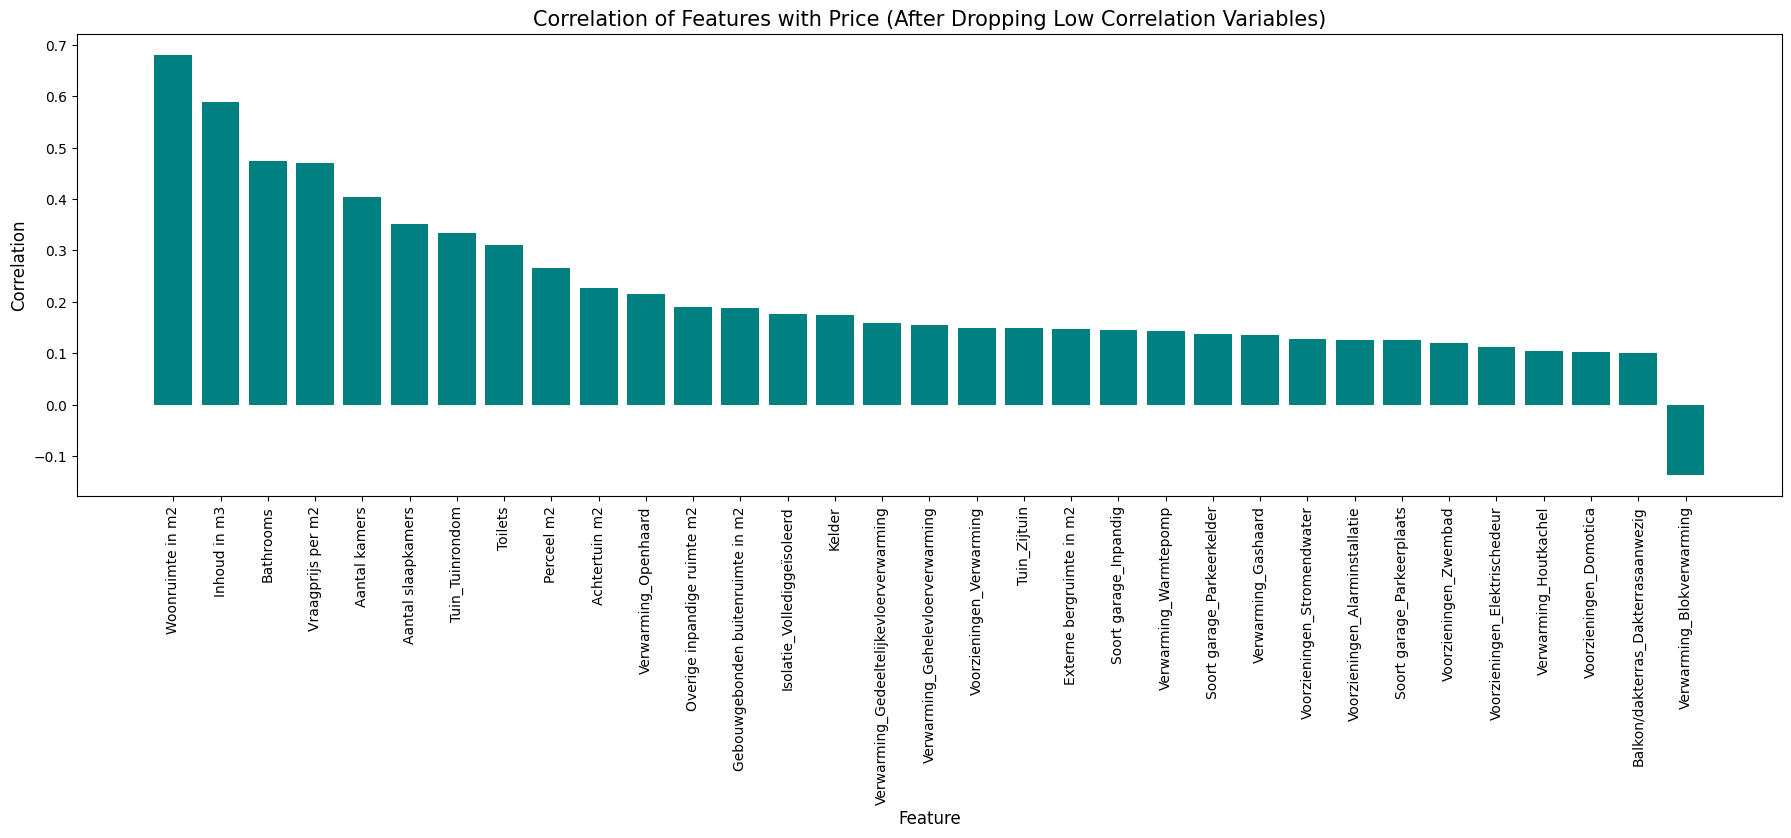

In [9]:

corr_matrix = data.corr()

# Select the variables that have a correlation less than 0.1 with the target variable
drop_list = corr_matrix[corr_matrix['Laatste vraagprijs'].abs() < 0.1].index.to_list()

data = data.drop(drop_list, axis=1)

plt.figure(figsize=(22,6))
plt.bar(x=list(data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs').index), height=list(data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs').values), color='teal')
plt.xticks(rotation=90)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.title('Correlation of Features with Price (After Dropping Low Correlation Variables)', fontsize=15)
plt.show()

In [10]:
data.shape

(9871, 40)

# **Split the Target variable from the input variables**

In [11]:
X = data.drop('Laatste vraagprijs',axis=1)
y = data['Laatste vraagprijs']

X.head()
X.describe()
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9871 entries, 0 to 9883
Data columns (total 39 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   Status                                   9871 non-null   object
 1   Soort bouw                               9871 non-null   object
 2   Aantal kamers                            9871 non-null   int64 
 3   Energielabel                             9871 non-null   object
 4   Overige inpandige ruimte m2              9871 non-null   int64 
 5   Perceel m2                               9871 non-null   int64 
 6   Achtertuin m2                            9871 non-null   int64 
 7   Aantal dagen tot verkoop                 9871 non-null   object
 8   Vraagprijs per m2                        9871 non-null   int64 
 9   Woonruimte in m2                         9871 non-null   int64 
 10  Gebouwgebonden buitenruimte in m2        9871 non-null   int

# **Split the data into Train and Test**

In [12]:
# Split the data into training and testing sets
X_train_full, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# **Transform Categorical variables by encoding**

In [13]:
from sklearn.preprocessing import StandardScaler

# transformers
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Select categorical columns with fewer than 1000 unique values
categorical_col = [col for col in X_train_full.columns if X_train_full[col].dtype == 'O' and X_train_full[col].nunique() < 1000]
# Print the selected categorical columns
print("Categorical Columns:")
print(categorical_col)

# Select numerical columns
numerical_col = [col for col in X_train_full.columns if X_train_full[col].dtype in ['float64', 'int64']]
# Print the selected numerical columns
print("Numerical Columns:")
print(numerical_col)

# Combine selected categorical and numerical columns
my_cols = categorical_col + numerical_col
# Create the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_col),
    ('cat', categorical_transformer, categorical_col)])


eval_set_pipe = Pipeline([
    ('preprocessor', preprocessor)
])

Categorical Columns:
['Status', 'Soort bouw', 'Energielabel', 'Aantal dagen tot verkoop', 'Soort dak', 'Soort woonhuis']
Numerical Columns:
['Aantal kamers', 'Overige inpandige ruimte m2', 'Perceel m2', 'Achtertuin m2', 'Vraagprijs per m2', 'Woonruimte in m2', 'Gebouwgebonden buitenruimte in m2', 'Externe bergruimte in m2', 'Inhoud in m3', 'Aantal slaapkamers', 'Bathrooms', 'Toilets', 'Kelder', 'Voorzieningen_Domotica', 'Voorzieningen_Zwembad', 'Voorzieningen_Verwarming', 'Voorzieningen_Stromendwater', 'Voorzieningen_Elektrischedeur', 'Voorzieningen_Alarminstallatie', 'Isolatie_Vollediggeïsoleerd', 'Verwarming_Gedeeltelijkevloerverwarming', 'Verwarming_Warmtepomp', 'Verwarming_Gehelevloerverwarming', 'Verwarming_Blokverwarming', 'Verwarming_Gashaard', 'Verwarming_Openhaard', 'Verwarming_Houtkachel', 'Balkon/dakterras_Dakterrasaanwezig', 'Tuin_Zijtuin', 'Tuin_Tuinrondom', 'Soort garage_Parkeerplaats', 'Soort garage_Inpandig', 'Soort garage_Parkeerkelder']


Categorical Columns:
['Status', 'Soort bouw', 'Energielabel', 'Aantal dagen tot verkoop', 'Soort dak', 'Soort woonhuis']
Numerical Columns:
['Aantal kamers', 'Overige inpandige ruimte m2', 'Perceel m2', 'Achtertuin m2', 'Vraagprijs per m2', 'Woonruimte in m2', 'Gebouwgebonden buitenruimte in m2', 'Externe bergruimte in m2', 'Inhoud in m3', 'Aantal slaapkamers', 'Bathrooms', 'Toilets', 'Kelder', 'Voorzieningen_Domotica', 'Voorzieningen_Zwembad', 'Voorzieningen_Verwarming', 'Voorzieningen_Stromendwater', 'Voorzieningen_Elektrischedeur', 'Voorzieningen_Alarminstallatie', 'Isolatie_Vollediggeïsoleerd', 'Verwarming_Gedeeltelijkevloerverwarming', 'Verwarming_Warmtepomp', 'Verwarming_Gehelevloerverwarming', 'Verwarming_Blokverwarming', 'Verwarming_Gashaard', 'Verwarming_Openhaard', 'Verwarming_Houtkachel', 'Balkon/dakterras_Dakterrasaanwezig', 'Tuin_Zijtuin', 'Tuin_Tuinrondom', 'Soort garage_Parkeerplaats', 'Soort garage_Inpandig', 'Soort garage_Parkeerkelder']


# **Define the eval_set_pipe with the preprocessor**

In [17]:
# Create the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_col),
 ('cat', categorical_transformer, categorical_col)])


eval_set_pipe = Pipeline([
    ('preprocessor', preprocessor)
])

# **Transform X_train and X_test without eval_set_pipe**

In [18]:


# Transform X_train and X_test without eval_set_pipe
X_train_eval = X_train_full[my_cols]
X_test_eval = X_test[my_cols]


# Convert the original data to DataFrames with the original index (no transformation)
X_train_eval_df = pd.DataFrame(X_train_eval, index=X_train_full.index)
X_test_eval_df = pd.DataFrame(X_test_eval, index=X_test.index)
X_test_eval_df.head()

,Status,Soort bouw,Energielabel,Aantal dagen tot verkoop,Soort dak,Soort woonhuis,Aantal kamers,Overige inpandige ruimte m2,Perceel m2,Achtertuin m2,...,Verwarming_Blokverwarming,Verwarming_Gashaard,Verwarming_Openhaard,Verwarming_Houtkachel,Balkon/dakterras_Dakterrasaanwezig,Tuin_Zijtuin,Tuin_Tuinrondom,Soort garage_Parkeerplaats,Soort garage_Inpandig,Soort garage_Parkeerkelder
6209,Verkocht,Bestaande bouw,B,29 days,Zadeldak bedekt met pannen,"Eengezinswoning, 2-onder-1-kapwoning",5,12,430,200,...,0,0,0,0,0,0,0,0,0,0
343,Verkocht,Nieuwbouw,None,113 days,Plat dak bedekt met bitumineuze dakbedekking,"Herenhuis, 2-onder-1-kapwoning",2,0,48,0,...,0,0,0,0,0,0,0,0,0,0
9788,Verkocht,Bestaande bouw,C,28 days,Plat dak bedekt met bitumineuze dakbedekking,"Eengezinswoning, hoekwoning (hofjeswoning)",6,0,97,0,...,0,0,0,0,0,0,0,0,0,0
3056,Verkocht,Bestaande bouw,B,14 days,Dwarskap bedekt met pannen,"Eengezinswoning, tussenwoning",5,0,122,58,...,0,0,0,0,0,0,0,0,0,0
6513,Verkocht,Bestaande bouw,F,26 days,Plat dak bedekt met bitumineuze dakbedekking,"Eengezinswoning, tussenwoning (hofjeswoning)",3,0,71,0,...,0,0,0,0,0,0,0,0,0,0


# **Transform X_train and X_test using eval_set_pipe**

In [19]:

column_names_df = pd.DataFrame([X_train_full[my_cols].columns])

# Transform X_train and X_test using eval_set_pipe
X_train_eval = eval_set_pipe.fit_transform(X_train_full[my_cols])
X_test_eval = eval_set_pipe.transform(X_test[my_cols])

# Convert the transformed data to DataFrames with the original index
X_train_eval_df = pd.DataFrame(X_train_eval, index=X_train_full.index)
X_test_eval_df = pd.DataFrame(X_test_eval, index=X_test.index)
X_test_eval_df

,0
6209,"(0, 1)\t1.2\n (0, 2)\t1.6787878787878787\n ..."
343,"(0, 0)\t-3.0\n (0, 2)\t-0.6363636363636364\..."
9788,"(0, 0)\t1.0\n (0, 2)\t-0.3393939393939394\n..."
3056,"(0, 2)\t-0.18787878787878787\n (0, 3)\t0.00..."
6513,"(0, 0)\t-2.0\n (0, 2)\t-0.49696969696969695..."
...,...
6096,"(0, 2)\t-0.1696969696969697\n (0, 3)\t-0.54..."
9380,"(0, 0)\t-2.0\n (0, 2)\t-0.4727272727272727\..."
3450,"(0, 0)\t-1.0\n (0, 2)\t2.109090909090909\n ..."
1970,"(0, 2)\t-0.11515151515151516\n (0, 3)\t-0.5..."


# **Random Forest Paramaeters without Tuning Exp 1**

In [20]:
from sklearn.ensemble import RandomForestRegressor

# Create a RandomForestRegressor model with default parameters
model_rf = RandomForestRegressor(random_state=42)

# Ensure the target variable is numeric
y_train_numeric = y_train.astype('float')

# Train  RandomForestRegressor model with default parameters
model_rf.fit(X_train_eval, y_train_numeric)

# Make predictions on the test set
y_test_pred_rf = model_rf.predict(X_test_eval)


# **Calculate various accuracy measures**

In [ ]:
# Calculate various accuracy measures
mse = mean_squared_error(y_test, y_test_pred_rf)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_test_pred_rf)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_test_pred_rf) / y_test)) * 100

# Print the accuracy measures
from sklearn import metrics
print('R2 Score_Random Forest Regression=',metrics.r2_score(y_test, y_test_pred_rf))


print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape, "%")


R2 Score_Random Forest Regression= 0.9922690310711463
Mean Squared Error (MSE): 334852100.1067467
Root Mean Squared Error (RMSE): 18298.96445449159
Mean Absolute Error (MAE): 4274.032379746835
Mean Absolute Percentage Error (MAPE): 0.8220059735050707 %


# **Plot the predicted sensitivity**

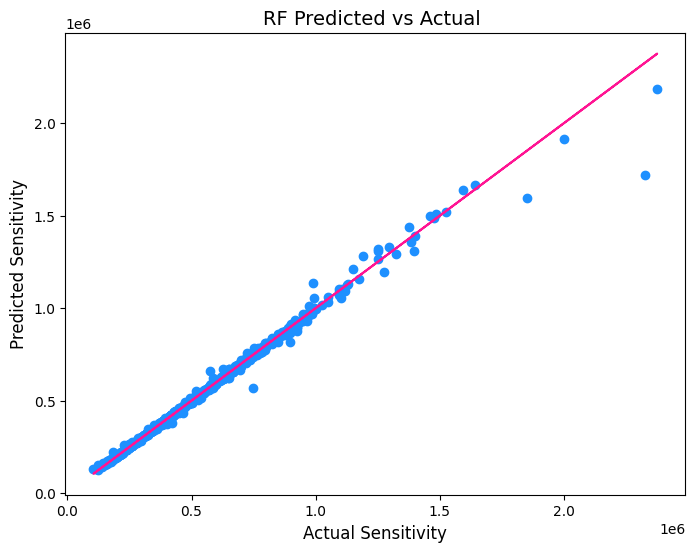

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Create a scatter plot of the actual and predicted sensitivity values
plt.figure(figsize=(8,6))
plt.scatter(x=y_test, y=y_test_pred_rf , color='dodgerblue')

# Add a 45-degree line to represent the perfect prediction
plt.plot(y_test,y_test, color='deeppink')

# Set the axis labels and title
plt.xlabel('Actual Sensitivity',fontsize=12)
plt.ylabel('Predicted Sensitivity',fontsize=12)
plt.title('RF Predicted vs Actual ',fontsize=14)


plt.show()

# **Make Predictions**

In [ ]:

X_test_eval = eval_set_pipe.transform(X_test.copy())

X_test_eval_df = pd.DataFrame(X_test_eval, index=X_test.index)

pred_test = model_rf.predict(X_test_eval)


predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred_rf})


print(predictions_df.head())

      Actual  Predicted
6209  369000   376505.0
343   525000   503600.0
9788  420000   422780.0
3056  350000   350265.0
6513  235000   232300.0
